In [1]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from keras.utils import plot_model
from matplotlib import image
from matplotlib import pyplot as plt
import os
import time
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')

## Allow GPU Utilization

In [2]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Define Constants

In [4]:
BATCH_SIZE = 32
EPOCHS = 150
IMG_HEIGHT = 150
IMG_WIDTH = 150
DATA_SPLIT = 2500
DATA_DIR = "data"
CHECKPOINTS_DIR = "training_checkpoints"
SAVED_IMAGES_DIR = "saved_images"
SAVED_MODEL_DIR = "saved_model"
MODEL_NAME = "model.h5"

## Load Data

In [5]:
from tensorflow import keras
tf.config.run_functions_eagerly(True)
x = []
y = []
for image_file in os.listdir( DATA_DIR )[ 0 : DATA_SPLIT ]:
    rgb_image = Image.open( os.path.join( DATA_DIR , image_file ) ).resize( ( IMG_WIDTH , IMG_HEIGHT ) )
    # Normalize the RGB image array
    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    gray_image = rgb_image.convert( 'L' )
    # Normalize the grayscale image array
    gray_img_array = ( np.asarray( gray_image ).reshape( ( IMG_WIDTH , IMG_HEIGHT , 1 ) ) ) / 255
    # Append both the image arrays
    x.append( gray_img_array )
    y.append( rgb_img_array )

### Split The Data

In [6]:
# Train-test splitting
train_x, test_x, train_y, test_y = train_test_split( np.array(x) , np.array(y) , test_size=0.1 )

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices( ( train_x , train_y ) )
dataset = dataset.batch( BATCH_SIZE )

## Visualize the data

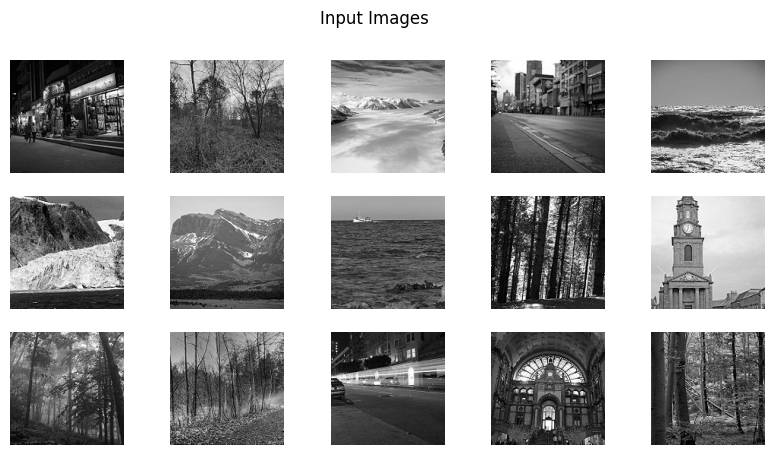

In [7]:
for images, labels in dataset.take(1):
    images = images.numpy()

    plt.figure(figsize=(10, 5))
    plt.suptitle('Input Images')
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.show()

## Define the Generator Model

In [8]:

def make_generator():

    inputs = tf.keras.layers.Input( shape=( IMG_HEIGHT , IMG_HEIGHT , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model

## Define the Discriminator Model

In [9]:
def make_discriminator():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=(IMG_HEIGHT, IMG_WIDTH , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' )
    ]
    model = tf.keras.models.Sequential( layers )
    return model



## Define the loss functions

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )


## Define the optimizers

In [11]:
generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )


## Define the models

In [12]:
generator = make_generator()
discriminator = make_discriminator()

## Define training Checkpoints

In [13]:
checkpoint_prefix = os.path.join(CHECKPOINTS_DIR, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training step

In [14]:
@tf.function
def train_step( input_x , real_y ):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator( input_x , training=True)
        # Compute the outputs
        real_output = discriminator( real_y, training=True)
        generated_output = discriminator(generated_images, training=True)
        # Compute the losses
        gen_loss = generator_loss( generated_images , real_y )
        disc_loss = discriminator_loss( real_output, generated_output )

        losses["D"].append(disc_loss.numpy())
        losses["G"].append(gen_loss.numpy())

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#  compile the models
generator.compile(
    optimizer=generator_optimizer,
    loss=generator_loss,
    metrics=['accuracy']
)

discriminator.compile(
    optimizer=discriminator_optimizer,
    loss=discriminator_loss,
    metrics=['accuracy']
)


## Plot the model

In [23]:
plot_model(generator, to_file='generator.png', show_shapes=True, show_layer_names=True, dpi=66)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [16]:
def plot_loss(losses):
    g_loss = []
    d_loss = []

    count = 0
    for i in losses['D']:
      count += 1
      if(count == 36):
        d_loss.append(i)
        count = 0

    count = 0
    for i in losses['G']:
      count += 1
      if(count == 36):
        g_loss.append(i)
        count = 0

    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

## Define the training loop

In [17]:
losses = {"D": [], "G": []}
for e in range(EPOCHS):
    start = time.time()
    checkpoint.save(file_prefix=checkpoint_prefix)
    print("Running epoch : ", e)
    for (x, y) in dataset:
        train_step(x, y)

    print('Time for epoch {} is {} sec'.format(
        e + 1, time.time()-start))

Running epoch :  0
Time for epoch 1 is 120.40101909637451 sec
Running epoch :  1
Time for epoch 2 is 87.50619626045227 sec
Running epoch :  2
Time for epoch 3 is 87.17906641960144 sec
Running epoch :  3
Time for epoch 4 is 87.43137836456299 sec
Running epoch :  4
Time for epoch 5 is 86.99109077453613 sec
Running epoch :  5
Time for epoch 6 is 87.47320413589478 sec
Running epoch :  6
Time for epoch 7 is 87.47896718978882 sec
Running epoch :  7
Time for epoch 8 is 87.56188797950745 sec
Running epoch :  8
Time for epoch 9 is 87.79938006401062 sec
Running epoch :  9
Time for epoch 10 is 87.5010199546814 sec
Running epoch :  10
Time for epoch 11 is 87.48317384719849 sec
Running epoch :  11
Time for epoch 12 is 87.70495200157166 sec
Running epoch :  12
Time for epoch 13 is 85.24406170845032 sec
Running epoch :  13
Time for epoch 14 is 78.87707781791687 sec
Running epoch :  14
Time for epoch 15 is 78.91450119018555 sec
Running epoch :  15
Time for epoch 16 is 78.92353796958923 sec
Running epo

## Restore the latest checkpoint

In [18]:
checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINTS_DIR))

In [19]:
y = generator( test_x[0 : ] ).numpy()

## Plot the losses

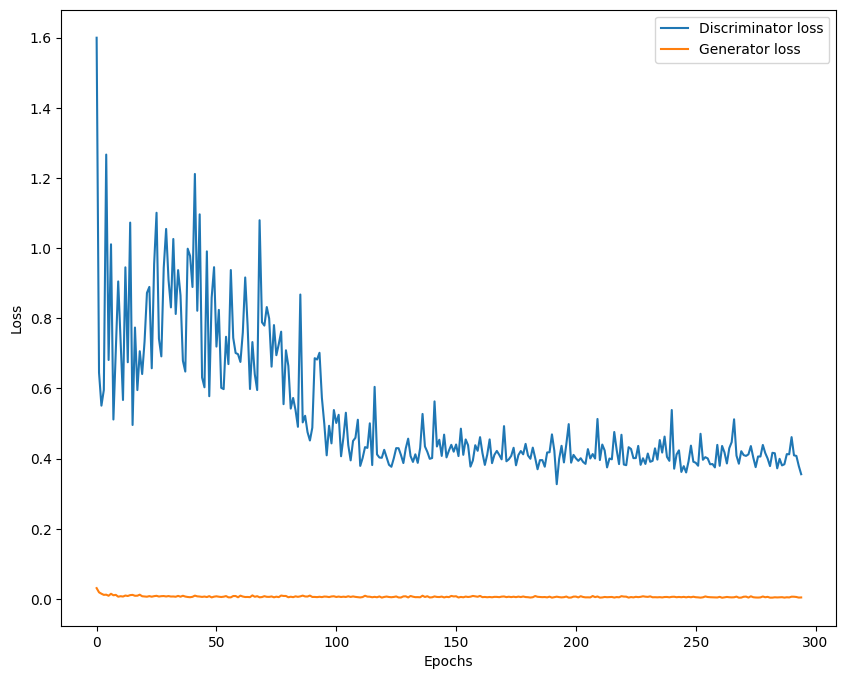

In [24]:
plot_loss(losses)

## Plot the results

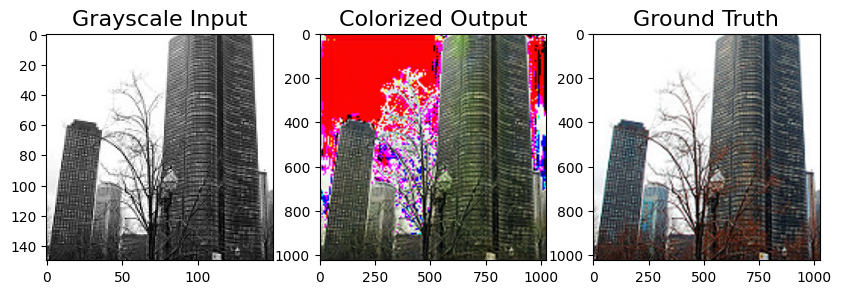

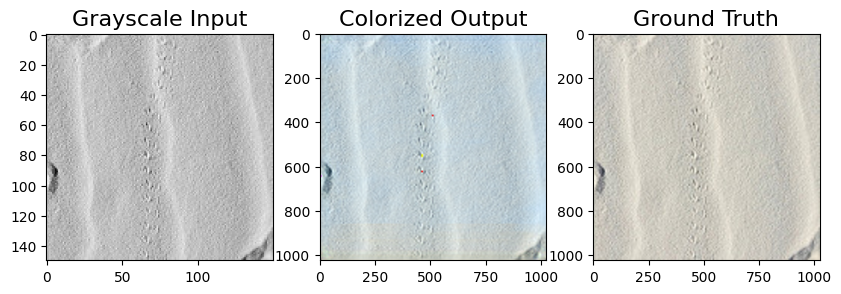

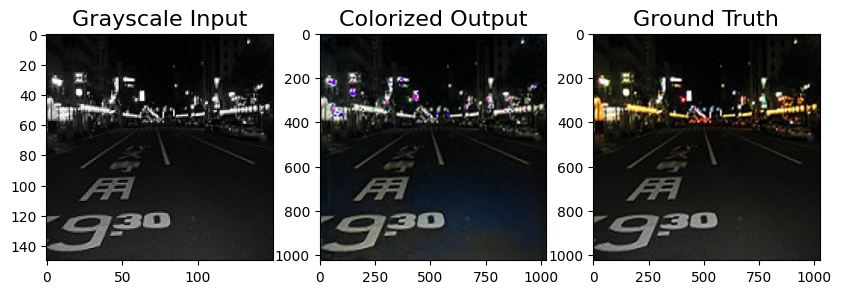

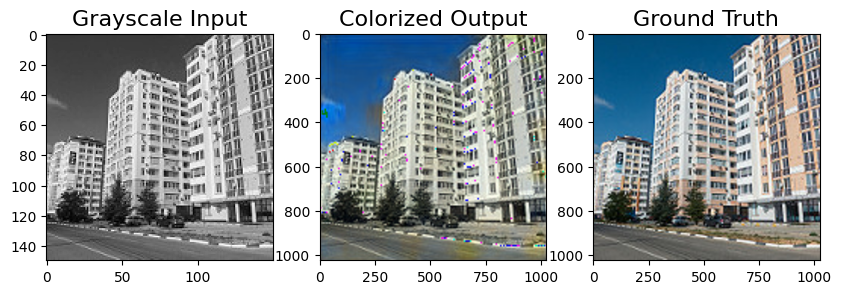

In [20]:
for i in range(11, 33, 7):
  plt.figure(figsize=(10,10))
  or_image = plt.subplot(3,3,1)
  or_image.set_title('Grayscale Input', fontsize=16)
  plt.imshow( test_x[i].reshape((150,150)) , cmap='gray' )

  in_image = plt.subplot(3,3,2)
  image = Image.fromarray( ( y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  image = np.asarray( image )
  in_image.set_title('Colorized Output', fontsize=16)
  plt.imshow( image )

  ou_image = plt.subplot(3,3,3)
  image = Image.fromarray( ( test_y[i] * 255 ).astype( 'uint8' ) ).resize( ( 1024 , 1024 ) )
  ou_image.set_title('Ground Truth', fontsize=16)
  plt.imshow( image )

  plt.show()

## Save the model

In [25]:
generator.save(SAVED_MODEL_DIR + "/" + MODEL_NAME)